# Q-Learning experiment runner

## Imports

In [1]:
%%capture
!pip install tqdm

In [2]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")

from tqdm import tqdm
import numpy as np
import pandas as pd

from typing import Tuple

In [3]:
from q_maze import QMaze, Action
from e_greedy_policy import EGreedyPolicy
from qlearning import QLearning

from qlearning_exp_functions import Results, train_ql_for_one_episode, run_ql_experiments

## Smoke test for QMaze, EGreedyPolicy and running on one episode

In [10]:
qm = QMaze(10)
# Reminder that QMaze.reset only returns agent state now.
# Be careful to capture the state when resetting, because the 
# Agent/entrance will move!
state = qm.reset()
eg_policy = EGreedyPolicy(epsilon=0.5, decay=0.9)
ql = QLearning(policy=eg_policy, environment=qm, gamma=0.9, alpha=0.01)


In [11]:
qm.display(debug=True)

X X X X X X X X X X 
X . . X A . X X . X 
X X . X X . . . . X 
X . . . X X X . X X 
X X X . X . X . . X 
X . . . X . . . X X 
X X X . X X X . . X 
X . . . . . X . X X 
X . X . X . . . . X 
X X X X X X X X O X 

{'maze_width': 10, 'maze_height': 10, 'size': 10, 'has_treasure': False, 'treasure_found': 0, 'treasure_left': 0, 'treasure_map': [], 'position_agent': (1, 4), 'position_entrance': (1, 4), 'position_exit': (9, 8), 'maze': array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 0, 0, 1, 2, 0, 1, 1, 0, 1],
       [1, 1, 0, 1, 1, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 1, 1, 1, 0, 1, 1],
       [1, 1, 1, 0, 1, 0, 1, 0, 0, 1],
       [1, 0, 0, 0, 1, 0, 0, 0, 1, 1],
       [1, 1, 1, 0, 1, 1, 1, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 1, 0, 1, 1],
       [1, 0, 1, 0, 1, 0, 0, 0, 0, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 3, 1]]), 'generation_start_coords': (8, 7), 'generation_start_neighbours': [], 'turns_elapsed': 0, 'done': False, 'coord_to_index_state': array([[27, 46, 95, 50, 74, 84, 90,  0, 37, 97

### One iteration to check policy is working with QLearning

113
-480


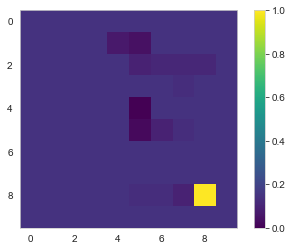

In [12]:
done = False
total_reward = 0

while not done:
    next_action = eg_policy(state, ql.q_value_store)
    next_state, reward, done = qm.step(next_action)
    next_action_index = next_action.value.index
    
    ql.update_q_values(
        current_state=state,
        next_action=next_action_index,
        next_reward=reward,
        next_state=next_state
    )

    eg_policy.update_epsilon()
    state = next_state
    total_reward += reward

print(qm.turns_elapsed)
print(total_reward)
vals = ql.display_q_values()
plt.imshow((vals - vals.min())/(vals.max() - vals.min()), cmap="viridis")
plt.colorbar()
plt.grid(False)
plt.show();

In [15]:
# The maze is solved
qm.display()

X X X X X X X X X X 
X . . X I . X X . X 
X X . X X . . . . X 
X . . . X X X . X X 
X X X . X . X . . X 
X . . . X . . . X X 
X X X . X X X . . X 
X . . . . . X . X X 
X . X . X . . . . X 
X X X X X X X X A X 



## Run for more episodes

Parameterise:
- epsilon for e-greedy
- gamma - discount factor
- alpha - learning rate or memory
- size of maze
- max reward
- decay - constant decay of epsilon

In [4]:
# Results = namedtuple("Results", "all_rewards, max_reward, mean_reward, var_reward, all_turns_elapsed, max_turns_elapsed, mean_turns_elapsed, var_turns_elapsed, mean_ending_epsilon")

In [5]:
# def train_ql_for_one_episode(environment: QMaze, q_learning_method: QLearning, policy: EGreedyPolicy) -> Tuple[int, int, float]:
#     state: int = environment.reset()
#     done: bool = False
#     total_reward: float = 0

#     while not done:
#         next_action = policy(state, q_learning_method.q_value_store)
#         next_state, reward, done = environment.step(next_action)
#         next_action_index = next_action.value.index
        
#         q_learning_method.update_q_values(
#             current_state=state,
#             next_action=next_action_index,
#             next_reward=reward,
#             next_state=next_state
#         )

#         policy.update_epsilon()
#         state = next_state
#         total_reward += reward

#     return total_reward, environment.turns_elapsed, policy.epsilon

In [6]:
# def run_ql_experiments(environment: QMaze, policy: EGreedyPolicy, q_learning_method: QLearning, num_episodes: int) -> Results:
#     all_rewards:list = []
#     all_turns_elapsed: list = []
#     all_ending_epsilon: list = []

#     for _ in range(num_episodes):

#         final_reward, final_turns_elapsed, final_epsilon = train_ql_for_one_episode(environment=environment, policy=policy, q_learning_method=q_learning_method)

#         # Record some information
#         all_rewards.append(final_reward)
#         all_turns_elapsed.append(final_turns_elapsed)
#         all_ending_epsilon.append(final_epsilon)

#     max_reward = max(all_rewards)
#     mean_reward = np.mean(all_rewards)
#     var_reward = np.std(all_rewards)

#     max_turns_elapsed = max(all_turns_elapsed)
#     mean_turns_elapsed = np.mean(all_turns_elapsed)
#     var_turns_elapsed = np.std(all_turns_elapsed)

#     mean_ending_epsilon = np.mean(all_ending_epsilon)
#     # policy.reset()

#     return Results(all_rewards, max_reward, mean_reward, var_reward, all_turns_elapsed, max_turns_elapsed, mean_turns_elapsed, var_turns_elapsed, mean_ending_epsilon)


In [7]:
def plot_mean_rewards_episodes(episode_idx: int, experiment_mean_rewards: list):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title(f"Last mean reward of {experiment_mean_rewards[-1]} after {episode_idx} episodes")
    plt.xlabel("Per 100 episodes")
    plt.ylabel("Mean reward")
    plt.plot(experiment_mean_rewards)
    plt.show()

def plot_turns_elapsed_episodes(episode_idx: int, experiment_mean_turns_elapsed: list):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title(f"Last turns elapsed of {experiment_mean_turns_elapsed[-1]} after {episode_idx} episodes")
    plt.xlabel("Per 100 episodes")
    plt.ylabel("Mean turns elapsed")
    plt.plot(experiment_mean_turns_elapsed)
    plt.show()

 21%|██        | 21/100 [00:02<00:05, 14.28it/s]Run: 10, ending epsilon: 0.0900567811781995, mean reward: -83.67, mean turns elapsed: 39.47, std reward: 231.64740684928896
Run: 20, ending epsilon: 0.0900567811781995, mean reward: -15.99, mean turns elapsed: 25.86, std reward: 169.16964828242683
 41%|████      | 41/100 [00:02<00:01, 30.38it/s]Run: 30, ending epsilon: 0.0900567811781995, mean reward: -4.85, mean turns elapsed: 24.28, std reward: 123.3792020561002
Run: 40, ending epsilon: 0.0900567811781995, mean reward: 45.62, mean turns elapsed: 14.9, std reward: 37.02857815255671
 61%|██████    | 61/100 [00:03<00:00, 46.57it/s]Run: 50, ending epsilon: 0.0900567811781995, mean reward: 42.4, mean turns elapsed: 15.67, std reward: 56.17312524686516
Run: 60, ending epsilon: 0.0900567811781995, mean reward: 44.55, mean turns elapsed: 15.39, std reward: 51.37399634056125
 81%|████████  | 81/100 [00:03<00:00, 60.84it/s]Run: 70, ending epsilon: 0.0900567811781995, mean reward: 48.63, mean turn

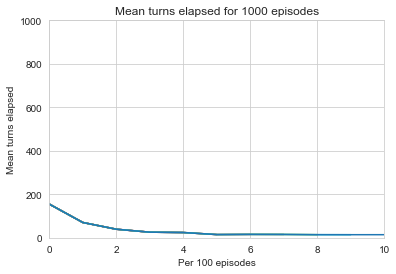

In [9]:
qm = QMaze(10)
eg_policy = EGreedyPolicy(epsilon=0.6, decay=0.9)
ql = QLearning(policy=eg_policy, environment=qm, gamma=0.9, alpha=0.01)

LOGGING_STEP_SIZE: int = 10
NUM_EPISODES: int = 1000
NUM_RUNS: int = 100
NUM_RUNS_TQDM = tqdm(range(NUM_RUNS))
NUM_LOGGED_EPISODES: int = 1000//LOGGING_STEP_SIZE

# Create structure to store data
all_results: list = []

# Plot rewards and timesteps
experiment_mean_rewards: list = []
experiment_mean_turns_elapsed: list = []

for run in NUM_RUNS_TQDM:
    if ((run % LOGGING_STEP_SIZE) == 0) or (run == 1):
        results = run_ql_experiments(environment=qm, policy=eg_policy, q_learning_method=ql, num_episodes=NUM_LOGGED_EPISODES)
        print(f"Run: {run}, ending epsilon: {eg_policy.epsilon}, mean reward: {results.mean_reward}, mean turns elapsed: {results.mean_turns_elapsed}, std reward: {results.var_reward}")
        all_results.append(results)
        experiment_mean_rewards.append(results.mean_reward)
        experiment_mean_turns_elapsed.append(results.mean_turns_elapsed)

        # Plot mean turns elapsed live
        plt.plot(experiment_mean_turns_elapsed);
        plt.title(f"Mean turns elapsed for {NUM_EPISODES} episodes");
        plt.xlabel(f"Per {NUM_LOGGED_EPISODES} episodes");
        plt.ylabel("Mean turns elapsed");
        plt.ylim([0, 1000]);
        plt.xlim([0, LOGGING_STEP_SIZE]);



X X X X X X X X X X 
X X X . . . X A . X 
X X . . X . . . X X 
X . . X X X X . X X 
X X X X . . . . . X 
X . . . . X X . X X 
X X X X X X . . . X 
X X X X X X . X . X 
X . . . . . . X . X 
X X X X X X X X O X 



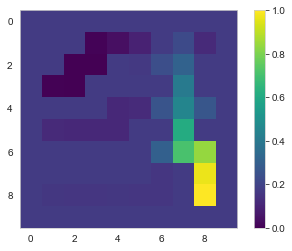

In [10]:
qm.reset()
qm.display()
results_vals = ql.display_q_values()
plt.imshow((results_vals - results_vals.min())/(results_vals.max() - results_vals.min()), cmap="viridis")
plt.colorbar()
plt.grid(False)
plt.show();


In [ ]:
# Plot rewards
plt.plot(experiment_mean_rewards);
plt.title(f"Mean rewards for {NUM_EPISODES} episodes");
plt.xlabel(f"Per {NUM_LOGGED_EPISODES} episodes");
plt.ylabel("Reward");
plt.ylim([-1000, 200]);
plt.xlim([0, LOGGING_STEP_SIZE]);

## Save results

In [142]:
results_df = pd.DataFrame(all_results)
results_df 

,all_rewards,max_reward,mean_reward,var_reward,all_turns_elapsed,max_turns_elapsed,mean_turns_elapsed,var_turns_elapsed,mean_ending_epsilon
0,"[-747, -3427, -14321, -2180, -3167, -448, -116...",32,-960.25,1684.913585,"[175, 740, 3107, 509, 706, 109, 256, 44, 187, ...",3107,227.53,360.708094,0.090057
1,"[-1415, -201, -713, -701, -217, -233, -1044, -...",60,-424.03,571.774229,"[321, 70, 167, 170, 70, 77, 263, 45, 23, 385, ...",601,114.73,120.380219,0.090057
2,"[-95, -131, -295, 44, -105, -48, -189, -76, -1...",74,-232.66,437.582089,"[45, 47, 85, 14, 43, 33, 56, 44, 57, 126, 196,...",512,73.71,93.962258,0.090057
3,"[72, -151, -215, -530, -70, 23, -7, 20, -64, -...",80,-59.26,133.252138,"[11, 62, 73, 117, 34, 18, 25, 22, 33, 127, 32,...",136,37.08,26.659587,0.090057
4,"[27, -6, 34, -1, 8, 4, -55, 64, -181, -3, 31, ...",72,-21.00,118.071927,"[16, 25, 17, 24, 22, 28, 32, 12, 63, 26, 18, 1...",170,29.23,24.186713,0.090057
5,"[57, -82, 32, 6, 54, 21, 47, 74, -77, 34, 48, ...",74,16.09,60.829449,"[14, 47, 19, 30, 15, 18, 15, 11, 36, 16, 15, 2...",90,21.85,12.160078,0.090057
6,"[51, -14, -4, 35, 0, 16, 66, 54, 25, 5, -40, 4...",72,3.94,124.459457,"[17, 30, 25, 17, 27, 21, 14, 14, 20, 21, 29, 1...",211,24.09,24.507997,0.090057
7,"[46, -29, 51, 64, 56, 41, 28, -79, 72, 50, -15...",75,10.21,92.505275,"[15, 27, 16, 14, 12, 21, 22, 44, 14, 17, 67, 2...",152,23.34,18.699850,0.090057
8,"[27, -32, 73, 47, 5, 48, 46, 60, 32, 44, -5, 5...",76,32.15,31.102211,"[19, 36, 14, 19, 20, 16, 16, 16, 19, 18, 27, 1...",51,18.97,6.019061,0.090057
9,"[33, 65, 65, 34, -19, 28, 57, 48, 57, 17, 65, ...",75,35.59,26.781746,"[19, 14, 14, 20, 28, 20, 12, 13, 15, 24, 12, 1...",38,18.09,4.874618,0.090057


## Test QMaze number of steps for different environment sizes

In [34]:
test_size_envs = range(5, 100)

for size_env in test_size_envs:
        test_qm = QMaze()
        test_eg_policy = EGreedyPolicy(epsilon=0.6, decay=0.9)
        test_ql = QLearning(policy=eg_policy, environment=qm, gamma=0.9, alpha=0.01)
        _, final_turns_elapsed, _ = train_ql_for_one_episode(environment=test_qm, policy=test_eg_policy, q_learning_method=test_ql)
        print(f"Size of env: {size_env}, final_turns_elapsed: {final_turns_elapsed}")

Size of env: 5, final_turns_elapsed: 80
Size of env: 6, final_turns_elapsed: 29
Size of env: 7, final_turns_elapsed: 64
Size of env: 8, final_turns_elapsed: 5
Size of env: 9, final_turns_elapsed: 23
Size of env: 10, final_turns_elapsed: 71
Size of env: 11, final_turns_elapsed: 9
Size of env: 12, final_turns_elapsed: 24
Size of env: 13, final_turns_elapsed: 41
Size of env: 14, final_turns_elapsed: 48
Size of env: 15, final_turns_elapsed: 45
Size of env: 16, final_turns_elapsed: 41
Size of env: 17, final_turns_elapsed: 23
Size of env: 18, final_turns_elapsed: 23
Size of env: 19, final_turns_elapsed: 8
Size of env: 20, final_turns_elapsed: 6
Size of env: 21, final_turns_elapsed: 13
Size of env: 22, final_turns_elapsed: 19
Size of env: 23, final_turns_elapsed: 22
Size of env: 24, final_turns_elapsed: 7
Size of env: 25, final_turns_elapsed: 31
Size of env: 26, final_turns_elapsed: 11
Size of env: 27, final_turns_elapsed: 44
Size of env: 28, final_turns_elapsed: 59
Size of env: 29, final_tur

In [15]:
epsilon_list = [0.5, 0.7, 0.9]
gamma_list = [0.5, 0.7, 0.9]
env_size_list = [10, 20, 30, 40, 50]

# mean_reward = []
# std_reward = []
    
# for size_envir in range(5,50,5):

#     # heuristics
#     n_improvement_steps = size_envir
#     n_steps_policy_eval = 10
    
#     total_rewards = []

#     for n_envir in range(n_environments_per_size):

#         dungeon = DungeonDP(size_envir)
#         policy = Policy(dungeon, gamma)
        
#         for n_improvements in range(n_improvement_steps):
    
#             policy.policy_iteration(n_steps_policy_eval)

#         all_total_rewards, _, _, _ = run_experiments(dungeon, policy, n_runs_per_environments)

#         total_rewards += all_total_rewards

#     mean_reward.append( np.mean(total_rewards) )
#     std_reward.append( np.std(total_rewards) )

# mean_reward = np.asarray(mean_reward)
# std_reward = np.asarray(std_reward)

# plt.plot(range(5, 50, 5), mean_reward, 'or')
# plt.plot(range(5, 50, 5), mean_reward, color = 'r')
# plt.fill_between(range(5, 50, 5), mean_reward - std_reward/2, mean_reward + std_reward/2,
#              color='r', alpha=0.2)

# plt.xlabel('Environment size')
# plt.ylabel('Average reward')

# plt.show()